# Import Required Libraries
Import the necessary libraries, including pandas and os.

In [2]:
# Import Required Libraries
import pandas as pd
import os

# Load Data Files into Dataset
Define a function to load CSV files following the pattern 'S{number}/S{number}_E4_Data/EDA.csv' into a pandas DataFrame.

In [3]:
import pandas as pd
import numpy as np
import os

# Lista para almacenar todos los DataFrames sincronizados
all_dataframes = []

# Definir las frecuencias de muestreo
fs_labels = 700  # Frecuencia de muestreo de labels en Hz
fs_EDA = 4       # Frecuencia de muestreo de EDA en Hz

# Bucle para cargar cada archivo de S2 a S17
for i in range(2, 18):
    # Construir la ruta del archivo
    file_path = f'S{i}\\S{i}.pkl'
    
    # Verificar si el archivo existe
    if os.path.exists(file_path):
        # Cargar los datos
        pkl_data = pd.read_pickle(file_path)
        labels = pkl_data['label']
        EDA = pkl_data['signal']['wrist']["EDA"]

        # Asegurar que los datos estén en una dimensión
        if isinstance(EDA, pd.DataFrame) or len(EDA.shape) > 1:
            EDA = EDA.squeeze()
        if isinstance(labels, pd.DataFrame) or len(labels.shape) > 1:
            labels = labels.squeeze()

        # Calcular la duración total basada en el número de muestras de EDA
        duration = len(EDA) / fs_EDA

        # Crear un vector de tiempo para EDA a 4 Hz
        time_EDA = np.linspace(0, duration, len(EDA))

        # Tomar cada 175ª muestra de labels para reducir la frecuencia a 4 Hz (700 / 4 = 175)
        labels_downsampled = labels[::int(fs_labels / fs_EDA)]

        # Asegurar que la longitud de labels_downsampled coincida con EDA
        if len(labels_downsampled) != len(EDA):
            labels_downsampled = labels_downsampled[:len(EDA)]

        # Crear el DataFrame final sincronizado para el participante actual
        df_synced = pd.DataFrame({
            'time': time_EDA,
            'label': labels_downsampled,
            'EDA': EDA,
            'PID': f'S{i}'  # Agregar la columna PID
        })

        # Agregar el DataFrame a la lista
        print(f"Participant S{i} - Shape: {df_synced.shape}")
        all_dataframes.append(df_synced)
    else:
        print(f"File {file_path} does not exist.")

# Concatenar todos los DataFrames en uno solo
df_all_participants_EDA = pd.concat(all_dataframes, ignore_index=True)

# Mostrar las primeras filas del DataFrame final
print(df_all_participants_EDA.head())


Participant S2 - Shape: (24316, 4)
Participant S3 - Shape: (25972, 4)
Participant S4 - Shape: (25692, 4)
Participant S5 - Shape: (25032, 4)
Participant S6 - Shape: (28284, 4)
Participant S7 - Shape: (20952, 4)
Participant S8 - Shape: (21864, 4)
Participant S9 - Shape: (20892, 4)
Participant S10 - Shape: (21984, 4)
Participant S11 - Shape: (20932, 4)
File S12\S12.pkl does not exist.
Participant S13 - Shape: (22148, 4)
Participant S14 - Shape: (22192, 4)
Participant S15 - Shape: (21008, 4)
Participant S16 - Shape: (22524, 4)
Participant S17 - Shape: (23680, 4)
       time  label       EDA PID
0  0.000000      0  1.138257  S2
1  0.250010      0  1.125444  S2
2  0.500021      0  1.011405  S2
3  0.750031      0  1.033188  S2
4  1.000041      0  0.935807  S2


# Preprocesamiento


### Identificacion de niveles de estres
Se considera 1 como estresado y 0 como no.
En este dataset los valores varían desde 0 hasta 6, identificando distintos estados de animo a lo largo de la sesión, siendo 2 como estresado es por eso que se convierten los valores que indiquen 2 a 1 y cualquier otro como 0.

In [4]:
df_all_participants_EDA['label'] = df_all_participants_EDA['label'].apply(lambda x: 1 if x == 2 else 0)

count_label_1 = df_all_participants_EDA['label'].sum()
print(f"Total count of label 1: {count_label_1}")

Total count of label 1: 39864


## Proceso de desconvolución

In [5]:
from cvxEDA import cvxEDA

# Crear una lista para almacenar los resultados de cada PID después de la desconvolución
results_list = []

# Obtener las combinaciones únicas de PID
unique_pids = df_all_participants_EDA['PID'].unique()

# Realizar la desconvolución para cada PID y almacenar los resultados
for pid in unique_pids:
    # Filtrar el DataFrame por el PID actual
    df_pid = df_all_participants_EDA[df_all_participants_EDA['PID'] == pid]
    
    # Preparar los datos para cvxEDA
    y = df_pid['EDA'].values
    t = df_pid['time'].values
    dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

    # Realizar la desconvolución
    [r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

    # Crear un nuevo DataFrame con los resultados de la desconvolución
    results = pd.DataFrame({
        'time': df_pid['time'],
        'original_EDA': y,
        'SCL': t,  # Componente tónica (Skin Conductance Level)
        'SCR': r,  # Componente fásica (Skin Conductance Response)
        'PID': pid,  # Añadir una columna para identificar el PID
        'label': df_pid['label'].values  # Incluir la etiqueta
    })
    
    # Añadir los resultados a la lista
    results_list.append(results)

# Concatenar todos los resultados en un solo DataFrame
all_results_EDA = pd.concat(results_list, ignore_index=True)

# Mostrar las primeras filas del DataFrame final con la desconvolución
print(all_results_EDA.head())

     pcost       dcost       gap    pres   dres
 0: -3.1812e+03 -3.1571e+03  4e+04  2e+02  6e-02
 1: -3.1593e+03 -5.8459e+03  3e+03  2e+01  4e-03
 2: -3.1580e+03 -3.4698e+03  3e+02  2e+00  4e-04
 3: -3.1616e+03 -3.2038e+03  4e+01  1e-01  4e-05
 4: -3.1749e+03 -3.1834e+03  8e+00  2e-02  5e-06
 5: -3.1800e+03 -3.1822e+03  2e+00  3e-03  9e-07
 6: -3.1814e+03 -3.1820e+03  6e-01  6e-04  2e-07
 7: -3.1818e+03 -3.1819e+03  1e-01  7e-05  2e-08
 8: -3.1819e+03 -3.1819e+03  4e-02  1e-05  4e-09
 9: -3.1819e+03 -3.1819e+03  1e-02  6e-07  2e-10
10: -3.1819e+03 -3.1819e+03  5e-03  7e-08  2e-11
11: -3.1819e+03 -3.1819e+03  2e-03  2e-08  5e-12
12: -3.1819e+03 -3.1819e+03  5e-04  3e-09  8e-13
13: -3.1819e+03 -3.1819e+03  2e-04  6e-10  2e-13
14: -3.1819e+03 -3.1819e+03  1e-04  9e-11  3e-14
15: -3.1819e+03 -3.1819e+03  4e-05  3e-11  1e-14
16: -3.1819e+03 -3.1819e+03  4e-05  2e-11  1e-14
17: -3.1819e+03 -3.1819e+03  1e-05  6e-12  4e-15
18: -3.1819e+03 -3.1819e+03  5e-06  7e-13  1e-14
19: -3.1819e+03 -3.18

In [6]:
all_results_EDA.head()

,time,original_EDA,SCL,SCR,PID,label
0,0.000000,1.138257,1.132551,0.000000,S2,0
1,0.250010,1.125444,1.125759,0.000000,S2,0
2,0.500021,1.011405,1.042284,-0.030879,S2,0
3,0.750031,1.033188,0.942543,0.089885,S2,0
4,1.000041,0.935807,0.886953,0.047996,S2,0


## Obtener el vector caracteristicas:
Feature Vector = [meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery ]

In [7]:
import pandas as pd
import numpy as np

# Definir el tamaño de la ventana en segundos
window_size = 30

# Crear una columna para identificar cada ventana en all_results_EDA_PPT
all_results_EDA['window'] = (all_results_EDA['time'] // window_size).astype(int)

# Función para calcular las características de cada ventana
def calculate_features(df):
    meanEDA = df['original_EDA'].mean()
    minEDA = df['original_EDA'].min()
    maxEDA = df['original_EDA'].max()
    stdEDA = df['original_EDA'].std()
    meanSCRonsets = df['SCR'].mean()  # Media de SCR (asumiendo que representa los onsets)
    meanSCRamp = df['SCR'].max() - df['SCR'].min()  # Amplitud como diferencia entre max y min
    meanSCRrecovery = df['SCR'].mean()  # Media de recuperación de SCR
    
    # Determinar si la ventana está estresada (1) o no (0)
    stressed = 1 if (df['label'] == 1).any() else 0
    
    # Devolver las características como una serie
    return pd.Series([meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery, stressed],
                     index=['meanEDA', 'minEDA', 'maxEDA', 'stdEDA', 'meanSCRonsets', 'meanSCRamp', 'meanSCRrecovery', 'stressed'])

# Agrupar por ventana y calcular características en all_results_EDA_PPT
segmented_results_EDA = all_results_EDA.groupby(['PID', 'window']).apply(calculate_features).reset_index()

# Mostrar las primeras filas del DataFrame resultante
print(segmented_results_EDA.head())


   PID  window   meanEDA    minEDA    maxEDA    stdEDA  meanSCRonsets  \
0  S10       0  0.349492  0.331306  0.360727  0.008502       0.000670   
1  S10       1  0.362966  0.355610  0.377356  0.002680       0.000770   
2  S10       2  0.359789  0.345377  0.372240  0.004399       0.001734   
3  S10       3  0.410818  0.363286  0.654937  0.057814       0.044707   
4  S10       4  0.388133  0.368402  0.431082  0.017912       0.001248   

   meanSCRamp  meanSCRrecovery  stressed  
0    0.006646         0.000670       0.0  
1    0.015091         0.000770       0.0  
2    0.064319         0.001734       0.0  
3    0.547776         0.044707       0.0  
4    0.008933         0.001248       0.0  


C:\Users\SCP-866\AppData\Local\Temp\ipykernel_19424\2319477211.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segmented_results_EDA = all_results_EDA.groupby(['PID', 'window']).apply(calculate_features).reset_index()


In [8]:
segmented_results_EDA["stressed"].value_counts()

stressed
0.0    2557
1.0     347
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split


subjects = segmented_results_EDA['PID'].unique()

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_subjects, test_subjects = train_test_split(subjects, test_size=0.214, random_state=42)  # 15% for validation and test
validation_subject, test_subjects = train_test_split(test_subjects, test_size=0.5, random_state=42)  # Split remaining into validation and test

# Mostrar los PID utilizados en cada conjunto
print("PID utilizados para entrenamiento:", train_subjects)
print("PID utilizados para validación:", validation_subject)
print("PID utilizados para prueba:", test_subjects)

# Crear los conjuntos de datos basados en los sujetos seleccionados
train_data = segmented_results_EDA[segmented_results_EDA['PID'].isin(train_subjects)]
validation_data = segmented_results_EDA[segmented_results_EDA['PID'].isin(validation_subject)]
test_data = segmented_results_EDA[segmented_results_EDA['PID'].isin(test_subjects)]

# Seleccionar el Feature Vector y la variable objetivo
features = ['meanEDA', 'minEDA', 'maxEDA', 'stdEDA', 'meanSCRonsets', 'meanSCRamp', 'meanSCRrecovery']
target = 'stressed'


# Preparar los datos de entrenamiento
X_train = train_data[features]
y_train = train_data[target]

# Preparar los datos de validación
X_validation = validation_data[features]
y_validation = validation_data[target]

# Preparar los datos de prueba
X_test = test_data[features]
y_test = test_data[target]

PID utilizados para entrenamiento: ['S16' 'S3' 'S13' 'S11' 'S9' 'S15' 'S2' 'S5' 'S7' 'S14' 'S17']
PID utilizados para validación: ['S4' 'S10']
PID utilizados para prueba: ['S6' 'S8']


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Función para evaluar el modelo
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, precision, recall, f1, mse

# Crear y entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn, precision_knn, recall_knn, f1_knn, mse_knn = evaluate_model(y_test, y_pred_knn)

# Crear y entrenar el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb, precision_nb, recall_nb, f1_nb, mse_nb = evaluate_model(y_test, y_pred_nb)

# Crear y entrenar el modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr, precision_lr, recall_lr, f1_lr, mse_lr = evaluate_model(y_test, y_pred_lr)

# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf, precision_rf, recall_rf, f1_rf, mse_rf = evaluate_model(y_test, y_pred_rf)

# Crear y entrenar el modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm, precision_svm, recall_svm, f1_svm, mse_svm = evaluate_model(y_test, y_pred_svm)

# Crear un DataFrame con las métricas de evaluación para cada modelo
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [accuracy_knn, accuracy_nb, accuracy_lr, accuracy_rf, accuracy_svm],
    'Precision': [precision_knn, precision_nb, precision_lr, precision_rf, precision_svm],
    'Recall': [recall_knn, recall_nb, recall_lr, recall_rf, recall_svm],
    'F1 Score': [f1_knn, f1_nb, f1_lr, f1_rf, f1_svm],
    'Mean Squared Error': [mse_knn, mse_nb, mse_lr, mse_rf, mse_svm]
})

# Mostrar los resultados en una tabla
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score  \
0                  KNN  0.789976   0.785989  0.789976  0.787975   
1          Naive Bayes  0.766110   0.848252  0.766110  0.798290   
2  Logistic Regression  0.894988   0.891157  0.894988  0.892935   
3        Random Forest  0.813842   0.785424  0.813842  0.799273   
4                  SVM  0.926014   0.919051  0.926014  0.918673   

   Mean Squared Error  
0            0.210024  
1            0.233890  
2            0.105012  
3            0.186158  
4            0.073986  


### Búsqueda en grilla

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Función para evaluar el modelo
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, precision, recall, f1, mse

# Definir el rango de parámetros para optimizar
param_grid = {
    'C': [0.1, 1, 10, 100],        # Regularización
    'kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'gamma': ['scale', 'auto']     # Coeficiente gamma para rbf/poly
}

# Crear el modelo base de SVM
svm_base = SVC()

# Aplicar Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica objetivo
    cv=5,                # Validación cruzada de 5 particiones
    verbose=2            # Mostrar detalles durante la búsqueda
)

# Ajustar la búsqueda en grilla
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y desempeño
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros SVM:", best_params)
print("Mejor puntaje de validación cruzada:", best_score)

# Entrenar el modelo final con los mejores hiperparámetros
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Evaluar el modelo final en el conjunto de prueba
y_pred_svm_optimized = best_svm_model.predict(X_test)
accuracy_svm_optimized, precision_svm_optimized, recall_svm_optimized, f1_svm_optimized, mse_svm_optimized = evaluate_model(y_test, y_pred_svm_optimized)

# Mostrar métricas finales
print(f"Accuracy: {accuracy_svm_optimized}")
print(f"Precision: {precision_svm_optimized}")
print(f"Recall: {recall_svm_optimized}")
print(f"F1 Score: {f1_svm_optimized}")
print(f"MSE: {mse_svm_optimized}")


KeyboardInterrupt: 

### Optimización Bayesiana

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

# Función para evaluar el modelo
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, precision, recall, f1, mse

# Definir la función objetivo para la optimización
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.1, 100)  # Búsqueda en escala logarítmica
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Crear el modelo SVM con los hiperparámetros seleccionados
    svm_model = SVC(C=C, kernel=kernel, gamma=gamma)

    # Validación cruzada para evaluar el desempeño
    score = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy').mean()

    # Optuna intenta maximizar esta métrica
    return score

# Crear el estudio de Optuna
study = optuna.create_study(direction='maximize')  # Maximizar la métrica
study.optimize(objective, n_trials=30)  # Realizar 30 pruebas

# Mostrar los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros SVM (Optuna):", study.best_params)
print("Mejor puntaje de validación cruzada:", study.best_value)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_svm_model_optuna = SVC(**best_params)
best_svm_model_optuna.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_svm_optuna = best_svm_model_optuna.predict(X_test)
accuracy_svm_optuna, precision_svm_optuna, recall_svm_optuna, f1_svm_optuna, mse_svm_optuna = evaluate_model(y_test, y_pred_svm_optuna)

# Mostrar métricas de evaluación
print(f"Accuracy: {accuracy_svm_optuna}")
print(f"Precision: {precision_svm_optuna}")
print(f"Recall: {recall_svm_optuna}")
print(f"F1 Score: {f1_svm_optuna}")
print(f"MSE: {mse_svm_optuna}")

# Puedes agregar estas métricas a tu tabla de resultados si lo deseas


[I 2024-12-05 00:14:33,421] A new study created in memory with name: no-name-724072c4-1eac-4b6a-a661-d4d2ad7b0120


C:\Users\SCP-866\AppData\Local\Temp\ipykernel_19424\1796123350.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100)  # Búsqueda en escala logarítmica
[I 2024-12-05 00:14:34,046] Trial 0 finished with value: 0.8820901173797804 and parameters: {'C': 0.3800303933570932, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.8820901173797804.
C:\Users\SCP-866\AppData\Local\Temp\ipykernel_19424\1796123350.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100)  # Búsqueda en escala logarítmica
[I 2024-12-05 00:14:36,399] Trial 1 finished with value: 0.8610042109852788 and parameter

### Implementación de XGB y MLP

#### XGB

In [ ]:
from xgboost import XGBClassifier

# Crear y entrenar el modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Hacer predicciones y evaluar
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, mse_xgb = evaluate_model(y_test, y_pred_xgb)

print("Métricas XGB:")
print(f"Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1: {f1_xgb}, MSE: {mse_xgb}")


### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

# Crear y entrenar el modelo MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Hacer predicciones y evaluar
y_pred_mlp = mlp_model.predict(X_test)
accuracy_mlp, precision_mlp, recall_mlp, f1_mlp, mse_mlp = evaluate_model(y_test, y_pred_mlp)

print("Métricas MLP:")
print(f"Accuracy: {accuracy_mlp}, Precision: {precision_mlp}, Recall: {recall_mlp}, F1: {f1_mlp}, MSE: {mse_mlp}")


# Interpretacion 


C:\Users\SCP-866\AppData\Local\Temp\ipykernel_7772\4042609270.py:17: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.


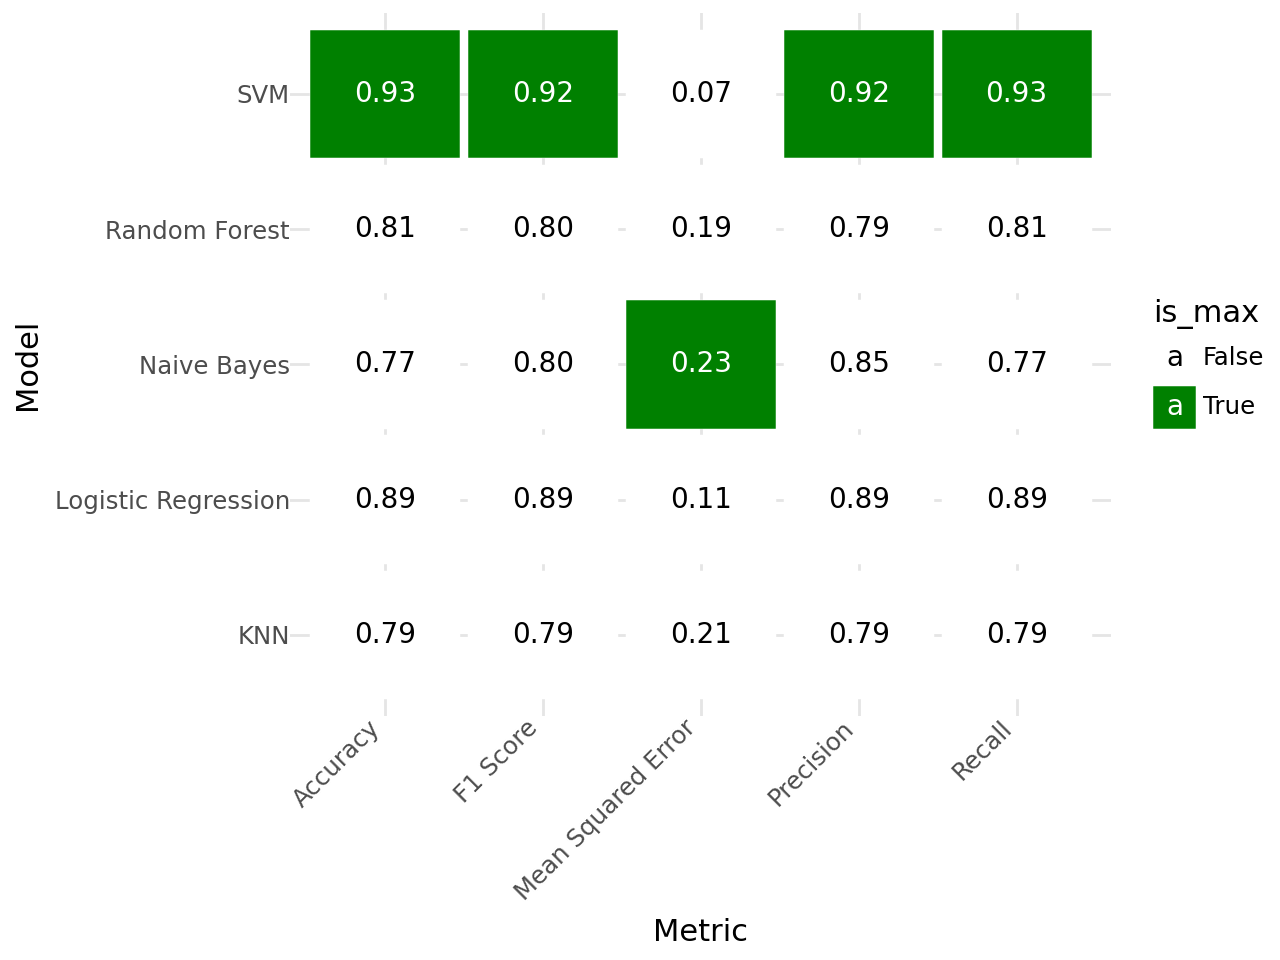

In [ ]:
from plotnine import ggplot, aes, geom_tile, geom_text, scale_color_manual, scale_fill_manual, theme_minimal, theme, element_text

# Crear un DataFrame actualizado con las métricas de evaluación
updated_results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM', 
              'Optimized SVM (Grid)', 'Optimized SVM (Bayesian)', 'XGB', 'MLP'],
    'Accuracy': [accuracy_knn, accuracy_nb, accuracy_lr, accuracy_rf, accuracy_svm, 
                 accuracy_svm_optimized, accuracy_svm_bayes, accuracy_xgb, accuracy_mlp],
    'Precision': [precision_knn, precision_nb, precision_lr, precision_rf, precision_svm, 
                  precision_svm_optimized, precision_svm_bayes, precision_xgb, precision_mlp],
    'Recall': [recall_knn, recall_nb, recall_lr, recall_rf, recall_svm, 
               recall_svm_optimized, recall_svm_bayes, recall_xgb, recall_mlp],
    'F1 Score': [f1_knn, f1_nb, f1_lr, f1_rf, f1_svm, 
                 f1_svm_optimized, f1_svm_bayes, f1_xgb, f1_mlp],
    'Mean Squared Error': [mse_knn, mse_nb, mse_lr, mse_rf, mse_svm, 
                           mse_svm_optimized, mse_svm_bayes, mse_xgb, mse_mlp]
})

# Convertir el DataFrame actualizado a formato largo para plotnine
updated_results_long = updated_results.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Identificar los valores máximos para cada métrica
max_values_updated = updated_results_long.groupby('Metric')['Value'].transform(max)
updated_results_long['is_max'] = updated_results_long['Value'] == max_values_updated

# Crear el gráfico de tabla actualizado
p = (ggplot(updated_results_long, aes(x='Metric', y='Model'))
             + geom_tile(aes(width=0.95, height=0.95, fill='is_max'), color='white')
             + geom_text(aes(label='Value', color='is_max'), format_string='{:.2f}', size=10)
             + scale_fill_manual(values=['white', 'green'])  # Relleno blanco para no máximos y verde para máximos
             + scale_color_manual(values=['black', 'white'])  # Texto negro para no máximos y blanco para máximos
             + theme_minimal()
             + theme(axis_text_x=element_text(rotation=45, hjust=1),
                     axis_text=element_text(size=10),
                     axis_title=element_text(size=12))
            )

# Mostrar el gráfico actualizado
p

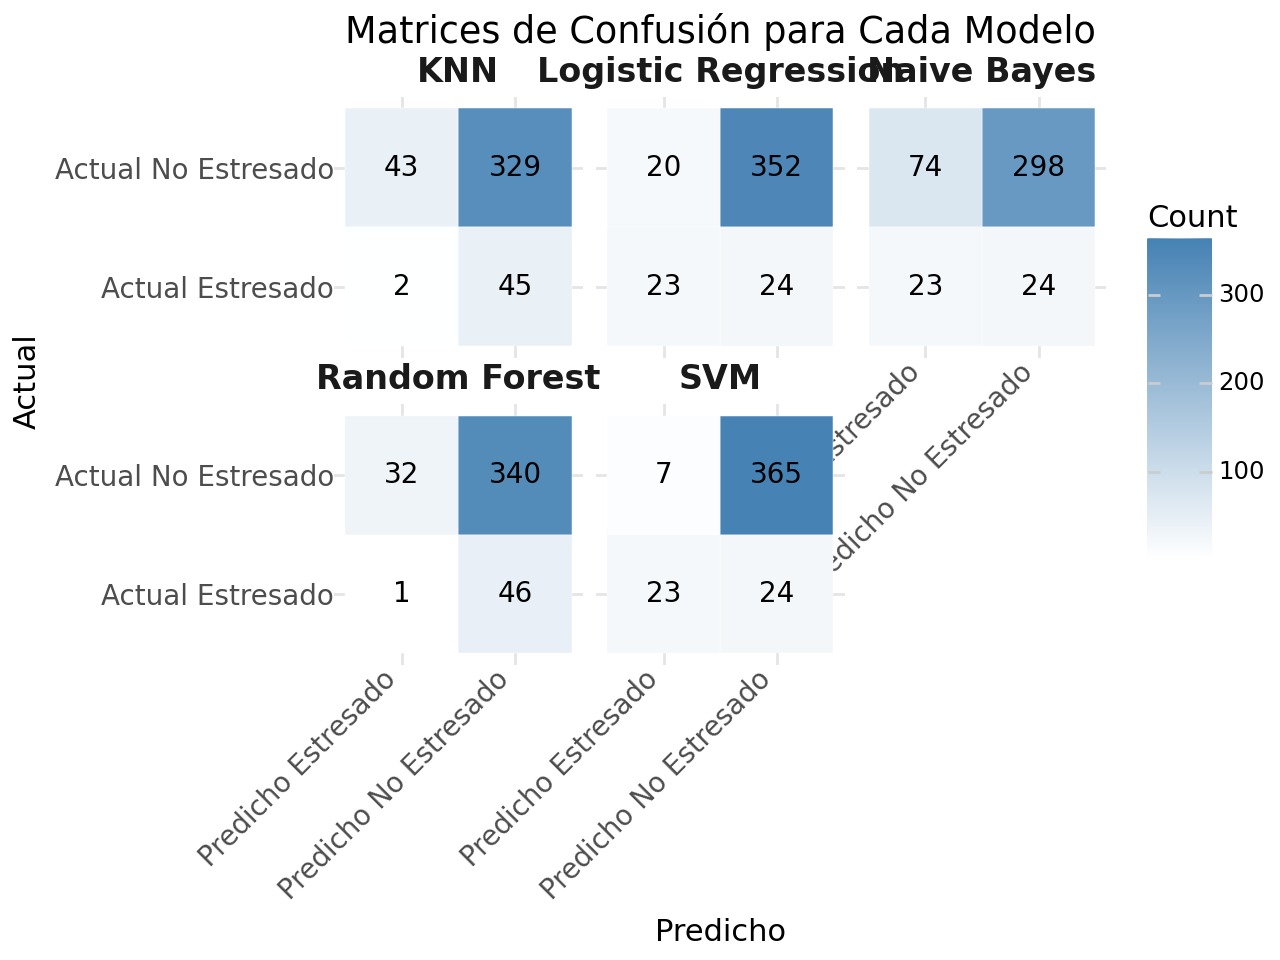

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import (
    ggplot, aes, geom_tile, geom_text, facet_wrap,
    scale_fill_gradient, theme_minimal, theme, element_text, ggtitle
)
# Asegurarse de que las longitudes de y_test y las predicciones sean consistentes
min_length = min(len(y_test), len(y_pred_knn), len(y_pred_nb), len(y_pred_lr), len(y_pred_rf), len(y_pred_svm))

# Recortar y_test y las predicciones a la longitud mínima
y_test_trimmed = y_test[:min_length]
y_pred_knn_trimmed = y_pred_knn[:min_length]
y_pred_nb_trimmed = y_pred_nb[:min_length]
y_pred_lr_trimmed = y_pred_lr[:min_length]
y_pred_rf_trimmed = y_pred_rf[:min_length]
y_pred_svm_trimmed = y_pred_svm[:min_length]

# Crear un diccionario con las predicciones recortadas
predictions = {
    'KNN': y_pred_knn_trimmed,
    'Naive Bayes': y_pred_nb_trimmed,
    'Logistic Regression': y_pred_lr_trimmed,
    'Random Forest': y_pred_rf_trimmed,
    'SVM': y_pred_svm_trimmed
}

# Calcular las matrices de confusión para cada modelo
conf_matrices = {}

for model_name, y_pred in predictions.items():
    cm = confusion_matrix(y_test_trimmed, y_pred)
    conf_matrices[model_name] = cm

# Convertir las matrices de confusión a un DataFrame en formato largo
conf_matrices_long = []

for model_name, cm in conf_matrices.items():
    cm_df = pd.DataFrame(cm, 
                         index=['Actual No Estresado', 'Actual Estresado'], 
                         columns=['Predicho No Estresado', 'Predicho Estresado'])
    cm_df = cm_df.reset_index().melt(id_vars='index', var_name='Predicho', value_name='Count')
    cm_df = cm_df.rename(columns={'index': 'Actual'})
    cm_df['Model'] = model_name
    conf_matrices_long.append(cm_df)

# Combinar todas las matrices en un solo DataFrame
conf_matrices_combined = pd.concat(conf_matrices_long, ignore_index=True)

# Crear el gráfico de las matrices de confusión usando plotnine
p = (
    ggplot(conf_matrices_combined, aes(x='Predicho', y='Actual')) +
    geom_tile(aes(fill='Count'), color='white') +
    geom_text(aes(label='Count'), size=10) +
    scale_fill_gradient(low='white', high='steelblue') +  # Escala continua de colores
    facet_wrap('~ Model') +  # Crear una faceta por cada modelo
    theme_minimal() +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1, size=10),
        axis_text_y=element_text(size=10),
        strip_text=element_text(size=12, weight='bold')
    ) +
    ggtitle('Matrices de Confusión para Cada Modelo')
)

p